# Sepsis-3 evaluation in the MIMIC-III database

This notebook goes over the evaluation of the new Sepsis-3 guidelines in the MIMIC database. The goals of this analysis include:

1. Evaluating the Sepsis-3 guidelines in MIMIC using the same methodology as in the research paper
2. Evaluating the Sepsis-3 guidelines against ANGUS criteria
3. Assessing if there are interesting subgroup(s) which are missed by the criteria

In [1]:
from __future__ import print_function

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sepsis_utils import sepsis_utils as su
from sepsis_utils import roc_utils as ru

# used to calculate AUROC/accuracy
from sklearn import metrics

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']

%matplotlib inline

In [2]:
# load data
df = pd.read_csv('sepsis3-df.csv',sep=',')
df_mdl = pd.read_csv('sepsis3-design-matrix.csv',sep=',')

# define outcome
target_header = "hospital_expire_flag"
y = df[target_header].values == 1

# define the covariates to be added in the MFP model (used for table of AUROCs)
preds_header = ['sirs','qsofa','sofa','mlods']

# Hospital mortality evaluation

In [3]:
# define targets, angus critera
# define "predictions" according to the SEPSIS-3 guidelines:
#  suspicion of infection, qSOFA >= 2, and SOFA >= 2
# this was done in the SQL code - so we pull the values here
yhat = df.sepsis3.values

print('\n SEPSIS-3 guidelines for hospital mortality \n')
# generate evaluation metrics
print('Accuracy = {}'.format(metrics.accuracy_score(y, yhat)))

su.print_cm(y, yhat) # print confusion matrix


 SEPSIS-3 guidelines for hospital mortality 

Accuracy = 0.549808992066

Confusion matrix
      	y=0   	y=1   
yhat=0	  3072	   278	NPV=91.70
yhat=1	  2786	   670	PPV=19.39
   	52.44	70.68	Acc=54.98
   	Spec	Sens


Predictions using various levels of confounder adjustment are calculated in the subfunctions `calc_predictions`:

* `model=None` - the severity scores on their own
* `model='baseline'` - the severity scores in a vanilla regression
* `model='mfp'` -the severity scores in a fractional polynomial regression (calls an R script)

In [4]:
preds = su.calc_predictions(df, preds_header, target_header, model=None)
preds_baseline = su.calc_predictions(df, preds_header, target_header, model='baseline')
preds_mfp = su.calc_predictions(df, preds_header, target_header, model='mfp')

In [5]:
# reproduce the AUC table
su.print_auc_table(preds, df[target_header].values, preds_header)
su.print_auc_table(preds_baseline, df[target_header].values, preds_header)
su.print_auc_table(preds_mfp, df[target_header].values, preds_header) # optional argument fixes order of output

su.print_auc_table_to_file(preds, df[target_header].values, preds_header=preds_header,
                           filename='auc-table-mort.csv')

su.print_auc_table_to_file(preds_mfp, df[target_header].values, preds_header=preds_header,
                           filename='auc-table-mort-mfp.csv')

     	sirs                	qsofa               	sofa                	mlods               	
sirs 	0.632 [0.615, 0.650]	                    	                    	                    	
qsofa	0.173               	0.618 [0.601, 0.634]	                    	                    	
sofa 	< 0.001               	< 0.001               	0.738 [0.720, 0.756]	                    	
mlods	< 0.001               	< 0.001               	0.261               	0.745 [0.727, 0.762]	
     	sirs                	qsofa               	sofa                	mlods               	
sirs 	0.730 [0.713, 0.746]	                    	                    	                    	
qsofa	0.038               	0.718 [0.701, 0.735]	                    	                    	
sofa 	< 0.001               	< 0.001               	0.783 [0.768, 0.799]	                    	
mlods	< 0.001               	< 0.001               	0.271               	0.788 [0.773, 0.804]	
     	sirs                	qsofa               	sofa                	mlods

## ROC curves

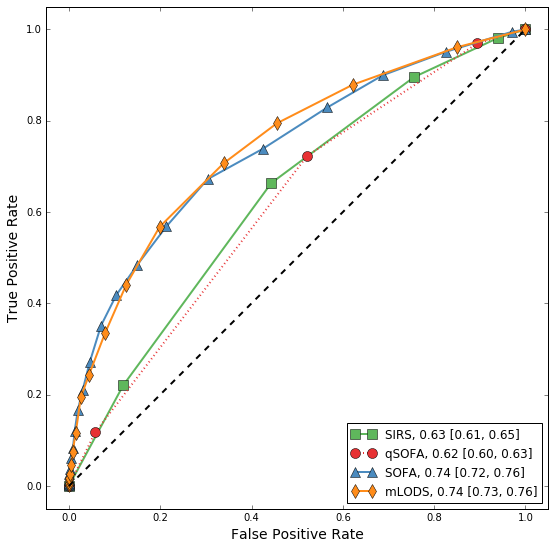

In [6]:
#preds_header = ['sirs','qsofa','sofa','mlods']
markers = {'qsofa': 'o:', 'sofa': '^-', 'sirs': 's-', 'mlods': 'd-'}
colors = {'qsofa': col[0], 'sofa': col[1], 'sirs': col[2], 'mlods': col[3]}
pred_pretty_text = {'qsofa': 'qSOFA', 'sofa': 'SOFA', 'sirs': 'SIRS', 'mlods': 'mLODS'}
# plot the data
plt.figure(figsize=[9,9])

# ROC for each score in preds header
for pred in preds_header:
    fpr, tpr, thr = metrics.roc_curve(y, df[pred].values)
    auc, auc_ci = ru.calc_auc(df[pred].values, y, with_ci=True, alpha=0.05)
    
    plt.plot(fpr, tpr, markers[pred],
             color=colors[pred], linewidth=2, markersize=10,
             label=pred_pretty_text[pred] + ', ' +
             '{:0.2f} [{:0.2f}, {:0.2f}]'.format(auc, auc_ci[0], auc_ci[1]))

plt.legend(loc="lower right")

plt.plot([0,1], [0,1], '--',
         color=[0,0,0], linewidth=2)
# reformat the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
#plt.title('ROC against in-hospital mortality',fontsize=14)
plt.show()

## Operating point statistics

In [7]:
# define "predictions" according to the SEPSIS-3 guidelines:
#  suspicion of infection, qSOFA >= 2, and SOFA >= 2
yhat_all = [df.sirs.values >= 2,
            df.qsofa.values >= 2,
            df.sofa.values >= 2,
            df.sepsis3.values,
            df.mlods.values >= 2]
yhat_names = ['SIRS', 'qsofa', 'sofa', 'seps3', 'mLODS']

# define "targets", angus critera
y_all = [y for x in yhat_names]

stats_all = su.print_op_stats(yhat_all, y_all,
               yhat_names=yhat_names,
               header=target_header)

Metric


          	SIRS                	qsofa               	sofa                	seps3               	mLODS               
TN        	 1430           	 2802           	 1014           	 3072           	 2218           
FP        	 4428           	 3056           	 4844           	 2786           	 3640           
FN        	   99           	  263           	   46           	  278           	  115           
TP        	  849           	  685           	  902           	  670           	  833           
Sens      	89.56 [0.87, 0.91]	72.26 [0.69, 0.75]	95.15 [0.94, 0.96]	70.68 [0.68, 0.74]	87.87 [0.86, 0.90]
Spec      	24.41 [0.23, 0.26]	47.83 [0.47, 0.49]	17.31 [0.16, 0.18]	52.44 [0.51, 0.54]	37.86 [0.37, 0.39]
PPV       	16.09 [0.15, 0.17]	18.31 [0.17, 0.20]	15.70 [0.15, 0.17]	19.39 [0.18, 0.21]	18.62 [0.17, 0.20]
NPV       	93.53 [0.92, 0.95]	91.42 [0.90, 0.92]	95.66 [0.94, 0.97]	91.70 [0.91, 0.93]	95.07 [0.94, 0.96]
F1        	27.28             	29.22             	26.95             

# Appendix

## Comparing binormal and empirical ROC


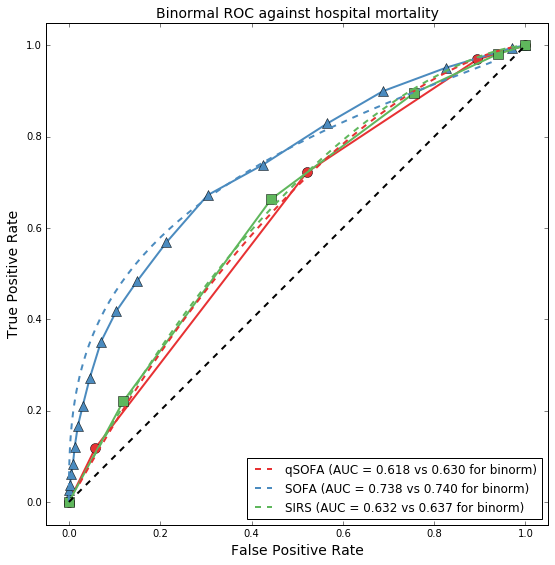

In [8]:
y = df.hospital_expire_flag.values == 1
plt.figure(figsize=[9,9])

# === NORMAL EMPIRICALLY DERIVED ROC

# ROC for qSOFA
fpr_qsofa, tpr_qsofa, thresholds_qsofa = metrics.roc_curve(y, df.qsofa.values)
auc_qsofa = metrics.auc(fpr_qsofa, tpr_qsofa)

# ROC for SOFA
fpr_sofa, tpr_sofa, thresholds_sofa = metrics.roc_curve(y, df.sofa.values)
auc_sofa = metrics.auc(fpr_sofa, tpr_sofa)


# ROC for SEPSIS-3
fpr_s3, tpr_s3, thresholds_s3 = metrics.roc_curve(y, (df.qsofa.values >= 2) & (df.sofa.values >= 2))
auc_s3 = metrics.auc(fpr_s3, tpr_s3)

# ROC for SIRS
fpr_sirs, tpr_sirs, thresholds_sirs = metrics.roc_curve(y, df.sirs.values)
auc_sirs = metrics.auc(fpr_sirs, tpr_sirs)

# plot the data
plt.plot(fpr_qsofa, tpr_qsofa, 'o-',
         color=col[0], linewidth=2, markersize=10)
plt.plot(fpr_sofa, tpr_sofa, '^-',
         color=col[1], linewidth=2, markersize=10)
plt.plot(fpr_sirs, tpr_sirs, 's-',
         color=col[2], linewidth=2, markersize=10)


# === BINORMAL ESTIMATED ROC

# ROC for qSOFA
fpr_qsofa, tpr_qsofa, thresholds_qsofa = ru.binormal_roc(df.qsofa.values[y], df.qsofa.values[~y])
auc_qsofa2 = ru.binormal_auroc(df.qsofa.values[y], df.qsofa.values[~y])

# ROC for SOFA
fpr_sofa, tpr_sofa, thresholds_sofa = ru.binormal_roc(df.sofa.values[y], df.sofa.values[~y])
auc_sofa2 = ru.binormal_auroc(df.sofa.values[y], df.sofa.values[~y])

# ROC for SIRS
fpr_sirs, tpr_sirs, thresholds_sirs = ru.binormal_roc(df.sirs.values[y], df.sirs.values[~y])
auc_sirs2 = ru.binormal_auroc(df.sirs.values[y], df.sirs.values[~y])

# plot the data
plt.plot(fpr_qsofa, tpr_qsofa, '--',
         color=col[0], linewidth=2, markersize=10,
         label='qSOFA (AUC = {:0.3f} vs {:0.3f} for binorm)'.format(auc_qsofa, auc_qsofa2))
plt.plot(fpr_sofa, tpr_sofa, '--',
         color=col[1], linewidth=2, markersize=10,
         label='SOFA (AUC = {:0.3f} vs {:0.3f} for binorm)'.format(auc_sofa, auc_sofa2))
plt.plot(fpr_sirs, tpr_sirs, '--',
         color=col[2], linewidth=2, markersize=10,
         label='SIRS (AUC = {:0.3f} vs {:0.3f} for binorm)'.format(auc_sirs, auc_sirs2))

plt.legend(loc="lower right")

plt.plot([0,1], [0,1], '--',
         color=[0,0,0], linewidth=2)
# reformat the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('Binormal ROC against hospital mortality',fontsize=14)
plt.show()

## Histograms comparing qSOFA in septic/non-septic population

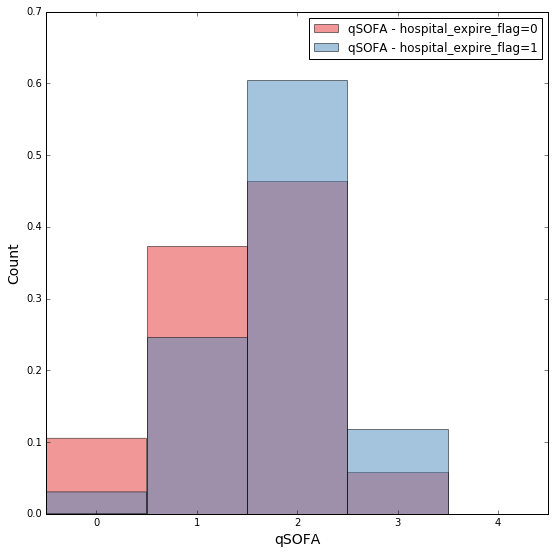

In [9]:
# histogram of the qSOFA values in septic/non-septic population
y = df.hospital_expire_flag.values == 1

qsofa_alive = df.qsofa.values[~y]
qsofa_dead = df.qsofa.values[y]

xi = [-0.5,0.5,1.5,2.5,3.5]

# plot the data
plt.figure(figsize=[9,9])
plt.hist(qsofa_alive, bins=xi, normed=True, color=col[0], alpha=0.5,
         label='qSOFA - ' + target_header + '=0')
plt.hist(qsofa_dead, bins=xi, normed=True, color=col[1], alpha=0.5,
         label='qSOFA - ' + target_header + '=1')

plt.legend(loc="upper right")

# reformat the plot
plt.xlim([-0.5,4.5])
#plt.ylim([-0.05, 1.05])
plt.xlabel('qSOFA',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.show()

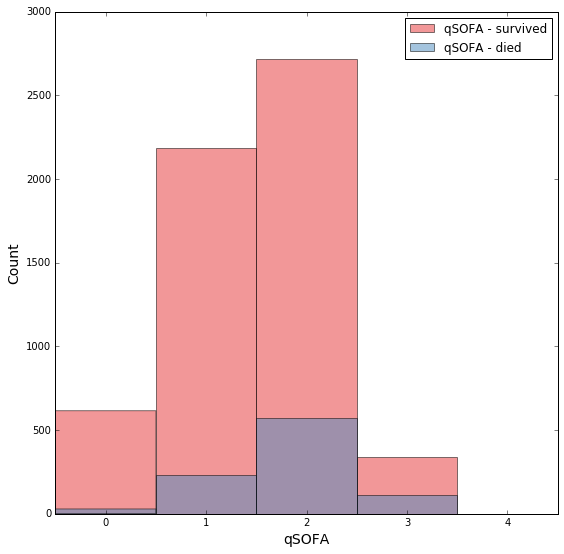

In [10]:
# histogram of the qSOFA values in septic/non-septic population
y = df.hospital_expire_flag.values == 1

qsofa_alive = df.qsofa.values[~y]
qsofa_dead = df.qsofa.values[y]

xi = [-0.5,0.5,1.5,2.5,3.5]

prevalence = np.mean(y)

# plot the data
plt.figure(figsize=[9,9])
n0, bins0, patches0 = plt.hist(qsofa_alive, bins=xi, normed=False, color=col[0], alpha=0.5,
         label='qSOFA - survived')
n1, bins1, patches1 = plt.hist(qsofa_dead, bins=xi, normed=False, color=col[1], alpha=0.5,
         label='qSOFA - died')

plt.legend(loc="upper right")

# reformat the plot
plt.xlim([-0.5,4.5])
#plt.ylim([-0.05, 1.05])
plt.xlabel('qSOFA',fontsize=14)
plt.ylabel('Count',fontsize=14)
#plt.title('ROC against hospital mortality',fontsize=14)
plt.show()

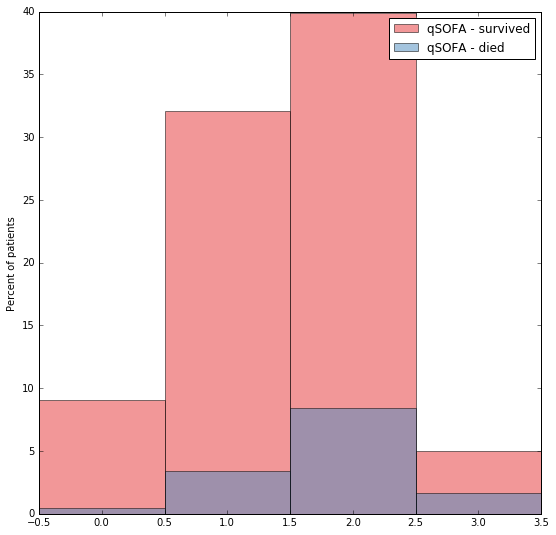

In [11]:
plt.figure(figsize=[9,9])

N = len(y)
plt.bar(bins0[0:-1], 100.0*n0/N, width=1, color=col[0], alpha=0.5,
         label='qSOFA - survived')
plt.bar(bins1[0:-1], 100.0*n1/N, width=1, color=col[1], alpha=0.5,
         label='qSOFA - died')
plt.legend()
plt.ylabel('Percent of patients')
plt.show()